In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from eggman.grid import luminosity, log_surface_gravity, calculate_eep, metallicity
from eggman.grid.defaults import MASS, YINI, ZINI, AGE, TEFF, RAD, DNUF, AMLT

import tensorflow as tf

print(f"Using TensorFlow {tf.__version__}")

FILENAME = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/dataset.h5"

print(f"Loading grid data from '{FILENAME}'.")
test = pd.read_hdf(FILENAME, "test")

2024-01-31 15:13:37.977368: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 15:13:37.977397: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 15:13:37.977422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 15:13:37.982788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 15:13:38.643845: W tensorflow/compiler/

Using TensorFlow 2.14.0
Loading grid data from '/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/dataset.h5'.


In [2]:
EEP = "EEP"
PHASE = "phase"
LUM = "L"
GRAV = "g"
LOG = "log"
SEP = "_"

# Separate features and labels
# features = [EEP, MASS, YINI, SEP.join([LOG, ZINI]), AMLT]
# labels = [SEP.join([LOG, key]) for key in [AGE, TEFF, RAD, DNUF]]
features = ["EEP", "star_mass", "M_H", "Yinit", "amlt"]
labels = [SEP.join([LOG, key]) for key in [AGE, TEFF, RAD, DNUF]]
num_features, num_labels = len(features), len(labels)

test_features = test[features].astype(np.float32).copy()
test_labels = test[labels].astype(np.float32).copy()

In [238]:
# DIR = '/mnt/data-storage/stellar-emulator/tuning/20231126-134236'
DIR = '/mnt/data-storage/stellar-emulator/tuning/20240131-132617'

project_name = "best_trial"
model = tf.keras.models.load_model(os.path.join(DIR, project_name, "checkpoint"))

In [239]:
with tf.device('/gpu:1'):
    test_pred = pd.DataFrame(model(test_features), columns=test_labels.columns, index=test_labels.index)
test_pred.head()

,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
7,7.733108,3.806669,-0.048647,2.169692
22,8.887025,3.805552,-0.031855,2.147676
24,8.936301,3.806123,-0.029857,2.144884
25,8.961034,3.806393,-0.028974,2.143630
30,9.066180,3.810004,-0.024052,2.135952


In [240]:
log_error = test_pred - test_labels
ln_error = log_error / np.log10(np.e)
error = 10**test_pred - 10**test_labels

In [241]:
num_samples = 10000
sample = test_labels.sample(num_samples)

Text(0, 0.5, 'log(L/Lsun)')

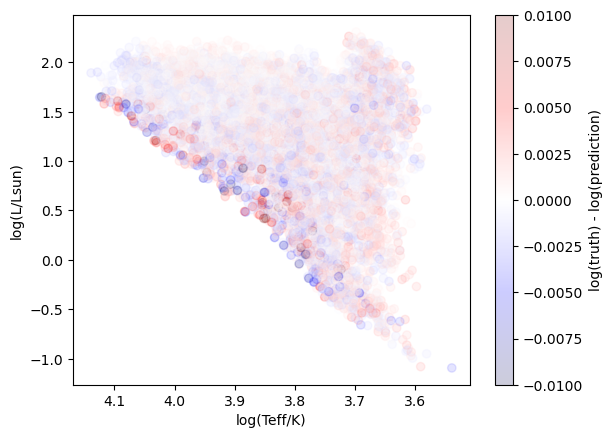

In [242]:
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, test.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.01, vmax=0.01)
fig.colorbar(s, label="log(truth) - log(prediction)")

ax.invert_xaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")

In [243]:
from matplotlib.colors import PowerNorm

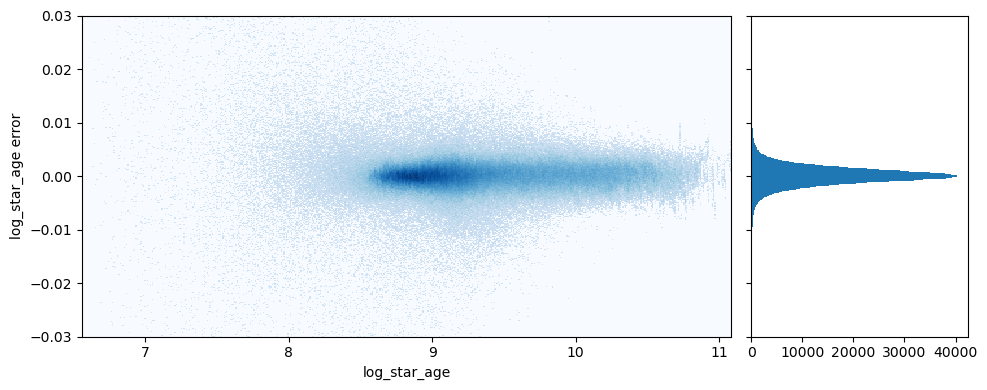

In [244]:
key = "log_star_age"
rlim = [
    [test[key].min(), test[key].max()], 
    [-0.03, 0.03]
]
gamma = 1/4

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
ax.hist2d(test[key], log_error[key], bins=500, range=rlim, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel(key)
ax.set_ylabel(f"{key} error")

ax = axes[1]
ax.hist(log_error[key], bins=500, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

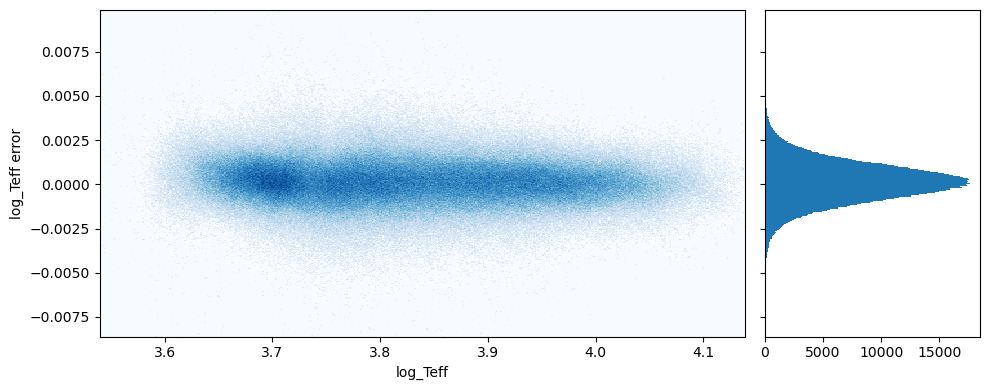

In [245]:
key = "log_Teff"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [log_error.loc[sample.index, key].min(), log_error.loc[sample.index, key].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
ax.hist2d(test[key], log_error[key], bins=500, range=rlim, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel(key)
ax.set_ylabel(f"{key} error")

ax = axes[1]
ax.hist(log_error[key], bins=500, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

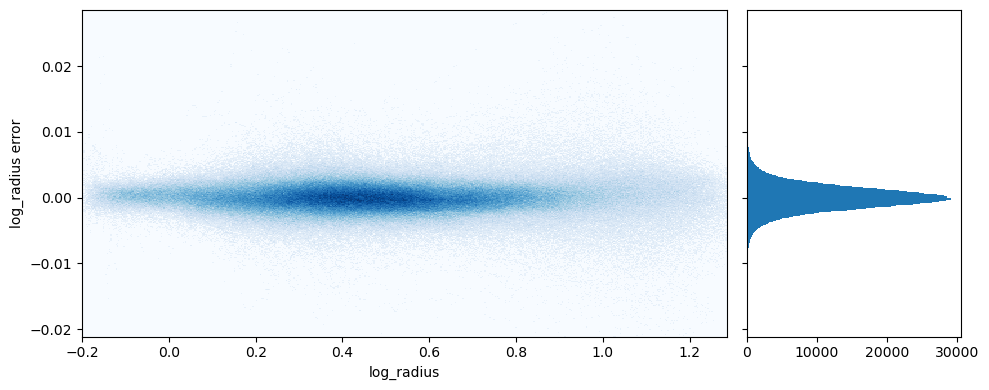

In [246]:
key = "log_radius"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [log_error.loc[sample.index, key].min(), log_error.loc[sample.index, key].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
ax.hist2d(test[key], log_error[key], bins=500, range=rlim, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel(key)
ax.set_ylabel(f"{key} error")

ax = axes[1]
ax.hist(log_error[key], bins=500, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

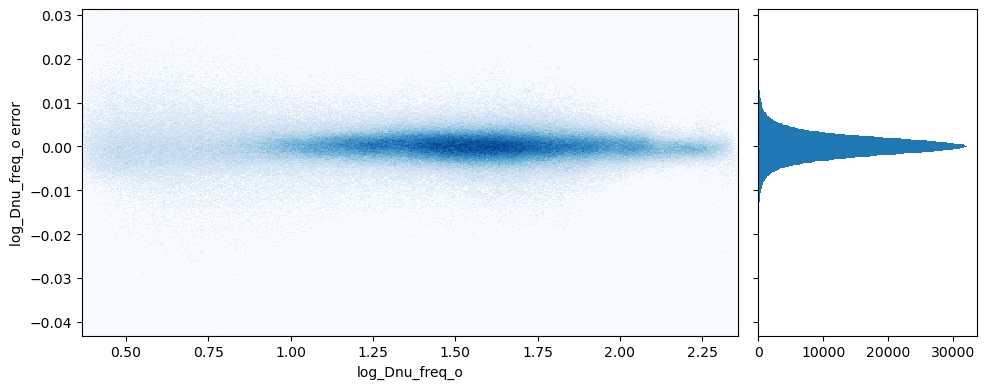

In [247]:
key = "log_Dnu_freq_o"
rlim = [
    [sample[key].min(), sample[key].max()], 
    [log_error.loc[sample.index, key].min(), log_error.loc[sample.index, key].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
ax.hist2d(test[key], log_error[key], bins=500, range=rlim, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel(key)
ax.set_ylabel(f"{key} error")

ax = axes[1]
ax.hist(log_error[key], bins=500, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

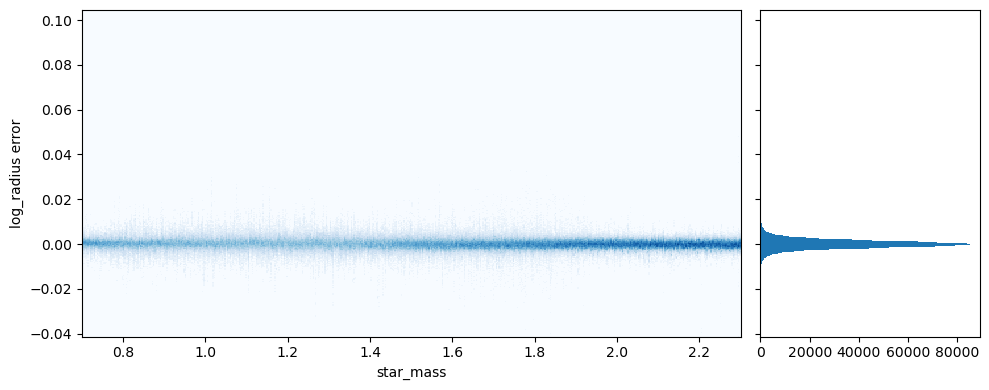

In [248]:
ykey = "log_radius"
xkey = "star_mass"
rlim = [
    [test[xkey].min(), test[xkey].max()], 
    [log_error[ykey].min(), log_error[ykey].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
ax.hist2d(test[xkey], log_error[ykey], bins=500, range=rlim, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel(xkey)
ax.set_ylabel(f"{ykey} error")

ax = axes[1]
ax.hist(log_error[ykey], bins=500, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

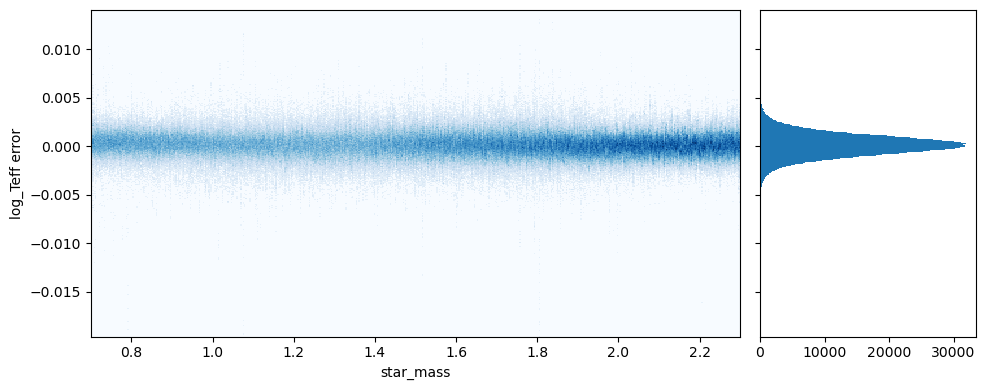

In [249]:
ykey = "log_Teff"
xkey = "star_mass"
rlim = [
    [test[xkey].min(), test[xkey].max()], 
    [log_error[ykey].min(), log_error[ykey].max()]
]
gamma = 1/2

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=dict(width_ratios=[3, 1]))

ax = axes[0]
ax.hist2d(test[xkey], log_error[ykey], bins=500, range=rlim, cmap="Blues", norm=PowerNorm(gamma=gamma))

ax.set_xlabel(xkey)
ax.set_ylabel(f"{ykey} error")

ax = axes[1]
ax.hist(log_error[ykey], bins=500, range=rlim[1], orientation="horizontal")
ax.set_ylim(rlim[1])

fig.tight_layout()

In [250]:
from corner import corner
import seaborn as sns

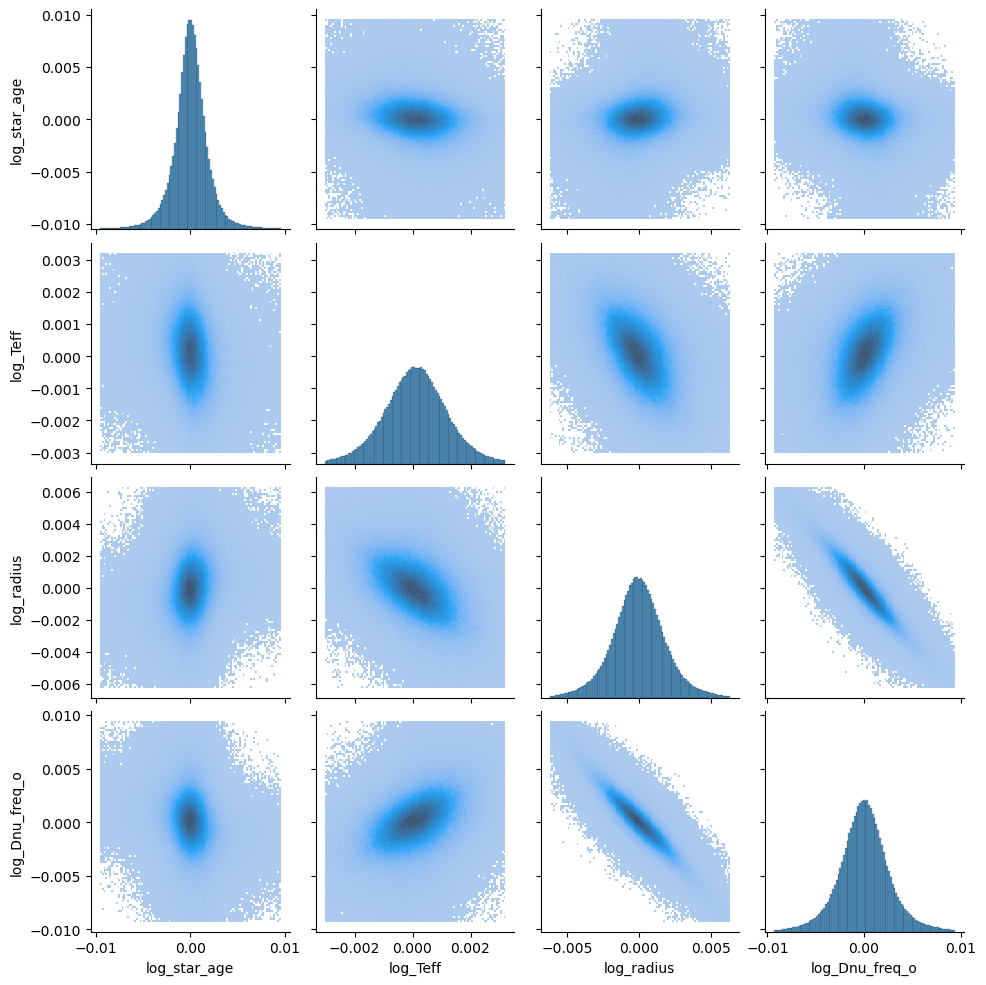

In [252]:
mask = (log_error > log_error.quantile(.01)) & (log_error < log_error.quantile(.99))

kws = dict(bins=100)
sns.pairplot(log_error.loc[mask.all(1)], kind="hist", diag_kind="hist", plot_kws=kws, diag_kws=kws);

In [253]:
quantiles = [.01, .16, .5, .84, .99]

In [254]:
log_error.quantile(quantiles)

,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
0.01,-0.009572,-0.003025,-0.006240,-0.009283
0.16,-0.001624,-0.000974,-0.001858,-0.002445
0.50,0.000034,0.000116,-0.000074,0.000028
0.84,0.001667,0.001189,0.001731,0.002510
0.99,0.009567,0.003199,0.006296,0.009417


In [255]:
error.quantile(quantiles)

,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
0.01,-1.260637e+08,-50.237559,-0.109238,-0.982600
0.16,-6.263316e+06,-15.415039,-0.013778,-0.197243
0.50,7.683200e+04,1.743652,-0.000402,0.001450
0.84,7.774208e+06,18.120117,0.012398,0.188095
0.99,1.441654e+08,50.965098,0.108356,0.891750


In [123]:
from scipy.stats import median_abs_deviation

In [124]:
median_abs_deviation(error)

array([3.5344320e+06, 1.2168457e+01, 8.9162588e-03, 1.2708950e-01],
      dtype=float32)

In [93]:
epoch = np.arange(5001)
alpha = np.array([1e-2])
lr = 1e-3 * np.ones(epoch.shape + alpha.shape)
lr_min = 1e-6
for i in epoch[1:]:
    condition = lr[i-1] < lr_min
    lr[i] = np.where(condition, lr[i-1], lr[i-1] * np.exp(-alpha))

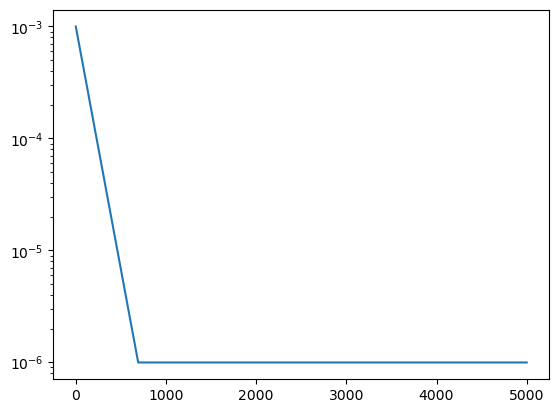

In [94]:
plt.plot(epoch, lr)
plt.yscale("log")

## To Do

- How propagates to parallax, luminosity etc.
- Start inference algorithm
    - 1 star
    - N stars
- In parallel train and improve emulator

In [95]:
test_pred["radius"] = 10**test_pred["log_radius"]
test_pred["Teff"] = 10**test_pred["log_Teff"]
test_pred["L"] = luminosity(test_pred)
test_pred["log_L"] = np.log10(test_pred["L"])

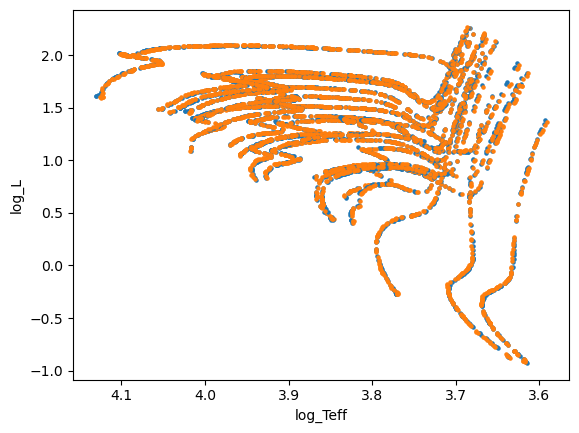

In [96]:
num_tracks = 20
random_state = 1
fig, ax = plt.subplots()
for ti in test.track.sample(num_tracks, random_state=random_state):
    mask = test.track == ti
    ax = test.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", marker=".", ax=ax)
    ax = test_pred.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

ax.invert_xaxis();

In [19]:
eep = np.linspace(0, 1., 201)
mass = np.ones_like(eep) * 1.
mh = np.zeros_like(eep)
yi = np.ones_like(eep) * 0.28
amlt = np.ones_like(eep) * 2.0

x = np.stack([eep, mass, mh, yi, amlt], -1)
y = model(x)

In [20]:
example = pd.DataFrame(x, columns=features)
example = example.join(pd.DataFrame(y, columns=labels))
example["radius"] = 10**example["log_radius"]
example["Teff"] = 10**example["log_Teff"]
example["L"] = luminosity(example)
example["log_L"] = np.log10(example["L"])
example.head()


,EEP,star_mass,M_H,Yinit,amlt,log_star_age,log_Teff,log_radius,log_Dnu_freq_o,radius,Teff,L,log_L
0,0.000,1.0,0.0,0.28,2.0,8.071685,3.768187,-0.037867,2.185976,0.916501,5863.900391,0.894758,-0.048294
1,0.005,1.0,0.0,0.28,2.0,8.554583,3.767831,-0.035794,2.182176,0.920886,5859.102539,0.900388,-0.045570
2,0.010,1.0,0.0,0.28,2.0,8.801621,3.767533,-0.031543,2.175795,0.929944,5855.083008,0.915671,-0.038260
3,0.015,1.0,0.0,0.28,2.0,8.972364,3.768496,-0.027267,2.170443,0.939147,5868.077148,0.942202,-0.025856
4,0.020,1.0,0.0,0.28,2.0,9.085553,3.769732,-0.023672,2.165095,0.946951,5884.807129,0.968898,-0.013722


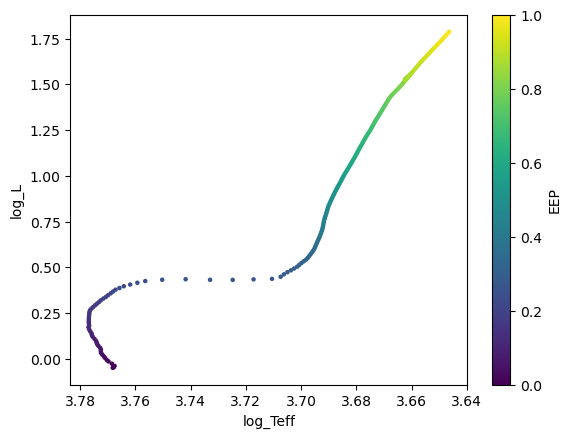

In [21]:
fig, ax = plt.subplots()

ax = example.plot(x="log_Teff", y="log_L", kind="scatter", c="EEP", marker=".", ax=ax)
ax.invert_xaxis();

<Axes: ylabel='Frequency'>

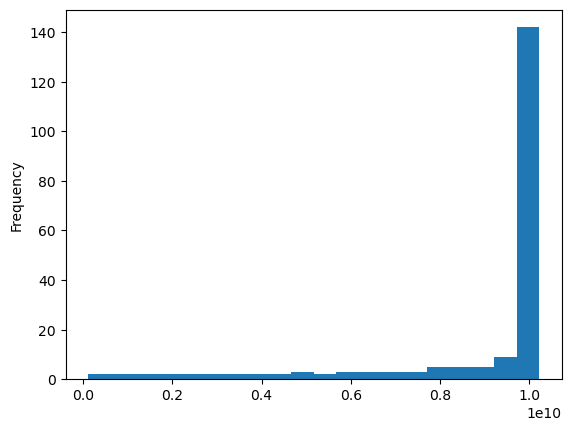

In [22]:
(10**example.log_star_age).plot(kind="hist", bins=20)